# Tarefas de Classificação 

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
import shutil
import random
from PIL import Image
from tqdm import tqdm
import cv2
import sys

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import activations
from keras.losses import CategoricalCrossentropy

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as lr
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score

In [5]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [6]:
plt.style.use('ggplot')
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 400

## Tarefa 1 - Separação em treino, teste e validação

In [7]:
class WorkWithDirs(object):
    def __init__(self, 
                 pct_treino=.7,
                 pct_teste=.2,
                 src_dir='data/src'):
        self.pct_treino, self.pct_teste = pct_treino, pct_teste
        self.src_dir = src_dir
    
    
    def _definir_classes_(self):
        """
        Ler o diretorio raiz e definir quais sao as classes, o diretorio deve ter a seguinte estrutura:
       
        src_dir
        ├── classe_1
        │   ├── img_1
        │   ├── img_2
        │   └── img_n
        ├── classe_2
        │   ├── img_1
        │   ├── img_2
        │   └── img_n
        └── classe_n
            ├── img_1
            ├── img_2
            └── img_n
            
        @returns:
            classes(list): list com as classes
        """
        classes =  os.listdir(self.src_dir)
        
        print(f'Total de classes encontradas: {len(classes)}\n{classes}')
        
        return classes

    
    def _listar_arquivos_(self, classes:list):
        """
        Ler o diretorio de cada classe e salvar em um dicionario
        
        @input
            classes(list): Lista com as classes, definida em _definir_classes_()
        @output
            files_dict(dict): dicionario no formato {classe_1:[img1, img2, ..., imgn], 
                                                     ..., 
                                                     classe_n:[img1, img2, ..., imgn]}
        """
        files_dict = {}
        
        for classe in self.classes:
            classe_dir = os.path.join(self.src_dir, classe)
            files_dict[classe] = [os.path.join(os.path.join(self.src_dir, classe), fname) for fname in os.listdir(classe_dir)]
            print(f'A classe {classe} possui {len(files_dict[classe])} imagens')
        
        return files_dict
            
    
    def _split_files_(self, files_dict:dict):
        """
        Criar um dicionario com base no objeto de saida da funcao self._listar_arquivos_
        em que cada chave representa uma classe e possui tres listas(treino, teste e dev),
        criadas por slice após a lista do dict base ser ordenada aleatoriamente. O tamanho de 
        cada conjunto é definido pelas variaveis pct_treino e pct_teste, declaradas ao inicializar a 
        classe, se pct_treino - pct_teste < 1 entao o restante vai para o conjunto dev. E essas proporçoes são
        aplicadas individualmente em cada classe
        
        @input:
            files_dict(dict): Dicionario com o path das imagen de cada classe, definido em _listar_arquivos_()
            
        @output:
            (dict): dicionario no formato {classe_1: 
                                                    treino:[img1, img2, ..., imgn],
                                                    teste:[img1, img2, ..., imgn],
                                                    dev:[img1, img2, ..., imgn]}
        """
        files_split_dict = {}
        
        print(f'A porcentagem de cada conjunto: {self.pct_treino*100}% para treino, {self.pct_teste*100}% teste e {(1-(self.pct_treino+self.pct_teste))*100}% validaçao')
        
        for classe in files_dict.keys():
            files_random_order = files_dict[classe]
            random.shuffle(files_random_order)
            
            len_treino = int(self.pct_treino * len(files_random_order))
            len_teste = int(self.pct_teste * len(files_random_order) + len_treino)
            
            files_split_dict[classe] = {"treino":files_random_order[:len_treino],
                                        "teste":files_random_order[len_treino:len_teste],
                                        "dev":files_random_order[len_teste:]}
            
            print(f'''A classe {classe} possui:
            {len(files_split_dict[classe]['treino'])} para treino
            {len(files_split_dict[classe]['teste'])} para teste
            {len(files_split_dict[classe]['dev'])} para validaçao''')
                        
        return files_split_dict
        
    
    def _criar_dirs_(self, 
                     classes:list,
                     split_dir_name:str='split',
                     set_names:list=['treino', 'teste', 'dev']):
        """
        Cria os diretorios de treino, teste e validacao com a estrutura:
        
        data
        ├── split_dir_name
        │   ├── dev
        │   │   ├── classe_1
        │   │   ├── classe_2
        │   │   └── classe_n
        │   ├── teste
        │   │   ├── classe_1
        │   │   ├── classe_2
        │   │   └── classe_n
        │   └── treino
        │       ├── classe_1
        │       ├── classe_2
        │       └── classe_n
        └── src
        
        Caso os diretorios existam, vao ser reescritos
        
        @input
            classes(list): lista com as classes definidas em _definir_classes_()
            split_dir_name(str): nome do diretorio a ser criado na pasta src_dir com os conjuntos
            set_names(list): lista com os nomes dos diretorios a serem criados no split_dir_name,
                             o nome dos diretorios devem ser os mesmos da chaves dentros das classes
                             no dict criado em _split_files_(). Default: ['treino', 'teste', 'dev']
        """
        self.dirs = {} # Dicionario com os diretorios criados
        
        def check_exists(dirname):
            if os.path.exists(dirname):
                print(f'O diretorio {dirname} ja existe, removendo ...')
                shutil.rmtree(dirname)
                print(f'O diretorio {dirname} foi excluido')
            
            print(f'Criando diretorio {dirname} ...')
            os.mkdir(dirname)
            print(f'Diretorio {dirname} criado')
                
        base_dir = os.path.dirname(self.src_dir)
        base_dir = os.path.join(base_dir, split_dir_name)
        
        check_exists(base_dir)        
        
        for set_name in set_names:
            set_path = os.path.join(base_dir, set_name)
            self.dirs[set_name] = set_path
            
            check_exists(set_path)
            
            for classe in classes:
                classe_path = os.path.join(set_path, classe)
                check_exists(classe_path)
                
                
    def _movefile_(self, filedict:dict, outdir='data/split'):
        """
        Para cada connjunto em cada classe do dict resultante de _split_files_()
        copia os arquivos dessa lista para o respectivo diretorio classe/set/ renomeando
        para img_1, img_2, ..., img_n
        
        Sendo que a imagens estao em formatos diferentes (jpg, png, jpeg, etc) e jpg por exemplo
        nao abre via tensorflow, entao vou convertertodas para png com o PIL, por essa parte pode 
        levar alguns minutos para executar a funcao
        
        @input:
            filedict(dict): Dicionario com os paths das imagens separadas por conjunto e classe, definido em _split_files_()
            outdir(str): nome do diretorio de saida dos arquivos
        """        
        for classe in filedict.keys():
            for conj in filedict[classe].keys():
                new_fdir = os.path.join(os.path.join(outdir, conj), classe)
                
                print(f'Copiando arquivos da classe {classe} para o conjunto {conj}')
                
                for idx, file  in tqdm(enumerate(filedict[classe][conj])):
                    img = Image.open(file)
                    
                    new_fname = f'img_{idx}.png'
                    out_path = os.path.join(new_fdir, new_fname)
                    
                    img.save(out_path)
        
        sys.stdout.write("]\n")
        
                    
    def create_dataset(self):
        self.classes = self._definir_classes_() # lista de classes
        self._criar_dirs_(classes=self.classes)
        files_dict = self._listar_arquivos_(classes=self.classes)
        sets_imgs = self._split_files_(files_dict=files_dict)
        self._movefile_(filedict=sets_imgs)

In [8]:
wwd = WorkWithDirs()

In [9]:
wwd.create_dataset()

3it [00:00, 29.10it/s]

Total de classes encontradas: 3
['Stormtrooper', 'Yoda', 'Darth Vader']
Criando diretorio data/split ...
Diretorio data/split criado
Criando diretorio data/split/treino ...
Diretorio data/split/treino criado
Criando diretorio data/split/treino/Stormtrooper ...
Diretorio data/split/treino/Stormtrooper criado
Criando diretorio data/split/treino/Yoda ...
Diretorio data/split/treino/Yoda criado
Criando diretorio data/split/treino/Darth Vader ...
Diretorio data/split/treino/Darth Vader criado
Criando diretorio data/split/teste ...
Diretorio data/split/teste criado
Criando diretorio data/split/teste/Stormtrooper ...
Diretorio data/split/teste/Stormtrooper criado
Criando diretorio data/split/teste/Yoda ...
Diretorio data/split/teste/Yoda criado
Criando diretorio data/split/teste/Darth Vader ...
Diretorio data/split/teste/Darth Vader criado
Criando diretorio data/split/dev ...
Diretorio data/split/dev criado
Criando diretorio data/split/dev/Stormtrooper ...
Diretorio data/split/dev/Stormtroope

454it [00:16, 28.03it/s]
3it [00:00, 23.58it/s]

Copiando arquivos da classe Stormtrooper para o conjunto teste


129it [00:04, 29.09it/s]
8it [00:00, 59.26it/s]

Copiando arquivos da classe Stormtrooper para o conjunto dev


66it [00:02, 32.69it/s]
4it [00:00, 29.15it/s]

Copiando arquivos da classe Yoda para o conjunto treino


341it [00:10, 32.24it/s]
3it [00:00, 21.97it/s]

Copiando arquivos da classe Yoda para o conjunto teste


97it [00:02, 33.43it/s]
5it [00:00, 47.98it/s]

Copiando arquivos da classe Yoda para o conjunto dev


50it [00:01, 39.83it/s]
4it [00:00, 28.88it/s]

Copiando arquivos da classe Darth Vader para o conjunto treino


482it [00:16, 28.84it/s]
3it [00:00, 24.44it/s]

Copiando arquivos da classe Darth Vader para o conjunto teste


138it [00:04, 30.53it/s]
2it [00:00, 18.66it/s]

Copiando arquivos da classe Darth Vader para o conjunto dev


70it [00:01, 35.99it/s]

]


## Tarefa 2 - Carregar imagens como tensores

* [Create dataset with Tensorflow](https://www.kaggle.com/freeman89/create-dataset-with-tensorflow)
* [Build an Image Dataset in TensorFlow](https://wizardforcel.gitbooks.io/tensorflow-examples-aymericdamien/content/5.1_build_an_image_dataset.html)
* [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [10]:
img_gen = keras.preprocessing.image.ImageDataGenerator

In [11]:
#!rm -r data/split/treino/.ipynb_checkpoints data/split/teste/.ipynb_checkpoints data/split/dev/.ipynb_checkpoints

In [12]:
w, h = 128, 128
bs = 50

In [13]:
# Com data aug para treino
idg_aug = img_gen(
    #zoom_range=.4,
    #brightness_range=(.2, .8),
    rotation_range=45,
    rescale=1./255,
    horizontal_flip=True,
)

# conj de teste e validacao sem aug
idg_test = img_gen(
    rescale=1./255
)

In [14]:
train_set = idg_aug.flow_from_directory(batch_size=bs,
                                        directory=wwd.dirs['treino'], 
                                        shuffle=True,
                                        target_size=(h, w),
                                        class_mode='categorical')

test_set = idg_test.flow_from_directory(batch_size=bs,
                                        directory=wwd.dirs['teste'],
                                        target_size=(h, w),
                                        class_mode='categorical')

dev_set = idg_test.flow_from_directory(batch_size=bs, 
                                       directory=wwd.dirs['dev'],
                                       target_size=(h, w),
                                       class_mode='categorical')

Found 1277 images belonging to 3 classes.
Found 364 images belonging to 3 classes.
Found 186 images belonging to 3 classes.


In [15]:
classLabels = dict(zip(train_set.class_indices.values(), train_set.class_indices.keys()))
classLabels

{0: 'Darth Vader', 1: 'Stormtrooper', 2: 'Yoda'}

## Tarefa 3 - Classificação com Machine Learning 

In [16]:
# Converter um tensor para np.array

def tensor2array(tf_gen:keras.preprocessing.image.DirectoryIterator):
    """
    Recebe um gerador do tensorflow e converte para um array com imagens e outro com labels, 
    como o batch size é menor que o total de imagens é preciso interar com o next()
    
    @input:
        tf_gen(keras.preprocessing.image.DirectoryIterator): Gerador de imagens a partir de um diretorio, 
                                                             gerado na funcao tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory()
    
    @output:
        x_idg(np.ndarray): Matriz de dim(len_imgs, weight, height, channels) com as imagens
        y_idg(np.ndarray): Matriz de dim(len_imgs, len_classes) com os labels   
    """
    x_idg, y_idg = [], []

    for i in range(tf_gen.__len__()):
        x, y = next(tf_gen)
        x_idg.append(x)
        y_idg.append(y)

    x_idg = np.concatenate(x_idg)
    y_idg = np.concatenate(y_idg)
    
    return(x_idg, y_idg)

In [17]:
def convImg(imgs:np.ndarray):
    """
    Normaliza a img para float32 (0, 1) e converte para escala em cinza
    
    @input:
        imgs(np.ndarray): Matriz com imagens gerada na funcao tensor2array()
    @output:
        img2gray = Matriz com imagens convertidas para escala em cinza com dim(len_imgs, weight*height)
    """
    x = []
    
    for idx in range(len(imgs)):
        img = cv2.cvtColor(imgs[idx], cv2.COLOR_BGR2GRAY)
        x.append(img)
        
    x = np.array(x)
    x = x.reshape(x.shape[0],x.shape[1]*x.shape[2])
    
    #return x/255.
    return x

In [18]:
def adjLabels(y_labels:np.ndarray):
    """
    A target que retorna da funcao tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory()
    é uma matriz do tipo [[c_1, c_2, c_3], ... [c_1, c_2, c_3]] em que c é a classe e o valor é 0 ou 1 se a
    imagem pertence ou nao aquela classe, isso nao serve para os modelos pois o traget deve ter dim 1, entao essa
    funcao converte essa matriz para um label tipo int de acordo com  o metodo 
    tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory().class_indices
    
    Obs: Essa nao é uma funcao generica, funciona apenas para 3 classes
    
    @input:
        y_labels(np.ndarray): Matriz com labels gerada na funcao tensor2array()
    @output:
        img2gray = Matriz labels com dim(len_imgs, 1)
    """
    y = []
    
    for label in y_labels:
        if (label == np.array([1., 0., 0.])).all():
            y.append(0)
        elif (label == np.array([0., 1., 0.])).all():
            y.append(1)
        elif (label == np.array([0., 0., 1.])).all():
            y.append(2)
        else:
            print('Deu ruim :-(')
        
    return np.array(y)

In [19]:
# Conjunto de treino

X_train, y_train = tensor2array(train_set)
X_train = convImg(X_train)
y_train = adjLabels(y_train)

In [20]:
# Unir conjunto de teste e validaçao
X_test, y_test = tensor2array(test_set)
X_dev, y_dev = tensor2array(dev_set) 

X_test = np.concatenate([X_test, X_dev])
y_test = np.concatenate([y_test, y_dev])

In [21]:
X_test = convImg(X_test)
y_test = adjLabels(y_test)

In [22]:
X_train.shape, y_train.shape

((1277, 16384), (1277,))

In [23]:
X_test.shape, y_test.shape 

((550, 16384), (550,))

### Regressão Logistica

* [Image Classification with Logistic Regression](https://www.kaggle.com/gulsahdemiryurek/image-classification-with-logistic-regression)

In [24]:
modelo_rl = lr()

In [25]:
modelo_rl.fit(X_train, y_train)

/home/lhnds/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [26]:
y_predict_rl = modelo_rl.predict(X_test)
y_prob_rl = modelo_rl.predict_proba(X_test)

In [27]:
acc_rl = accuracy_score(y_test, y_predict_rl)
print(f'Acuracia do modelo Regressao Logistica: {round(acc_rl*100, 2)}%')

Acuracia do modelo Regressao Logistica: 49.09%


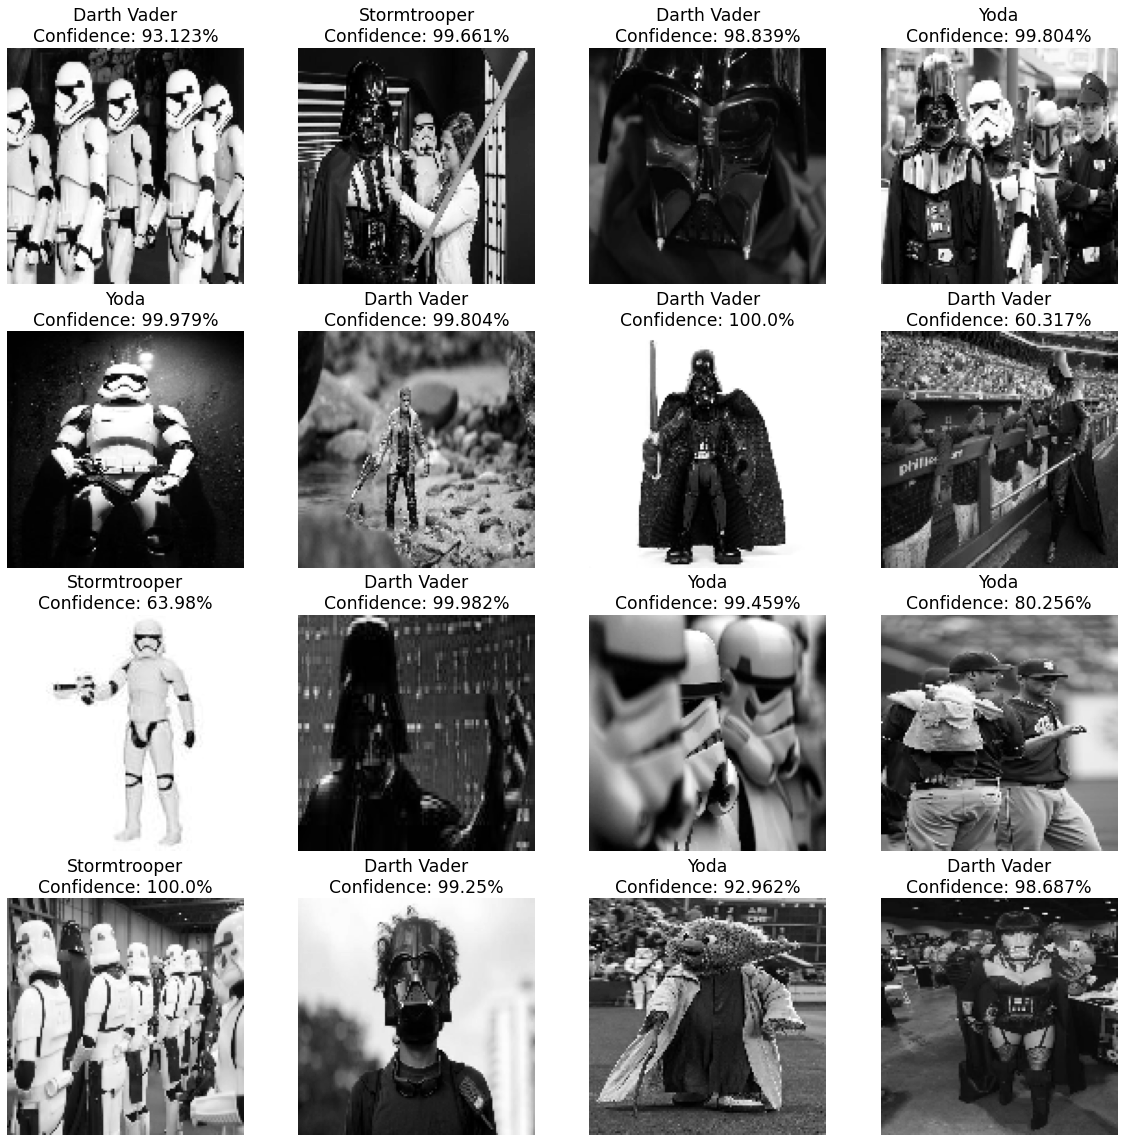

In [28]:
plt.figure(figsize=(20, 20))
for i, img in enumerate(X_test[:16]):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.reshape(h, w), cmap='gray')
    lbl = classLabels[y_predict_rl[i]] + '\nConfidence: ' + str(round(y_prob_rl[i][y_predict_rl[i]]*100, 3)) + '%'
    plt.title(lbl)
    plt.axis("off")

### SVM

In [29]:
modelo_svm = SVC(probability=True)

In [30]:
modelo_svm.fit(X_train, y_train)

SVC(probability=True)

In [31]:
y_predict_svm = modelo_svm.predict(X_test)
y_prob_svm = modelo_svm.predict_proba(X_test)

In [32]:
acc_svm = accuracy_score(y_test, y_predict_svm)
print(f'Acuracia do modelo svm: {round(acc_svm*100, 2)}%')

Acuracia do modelo svm: 67.27%


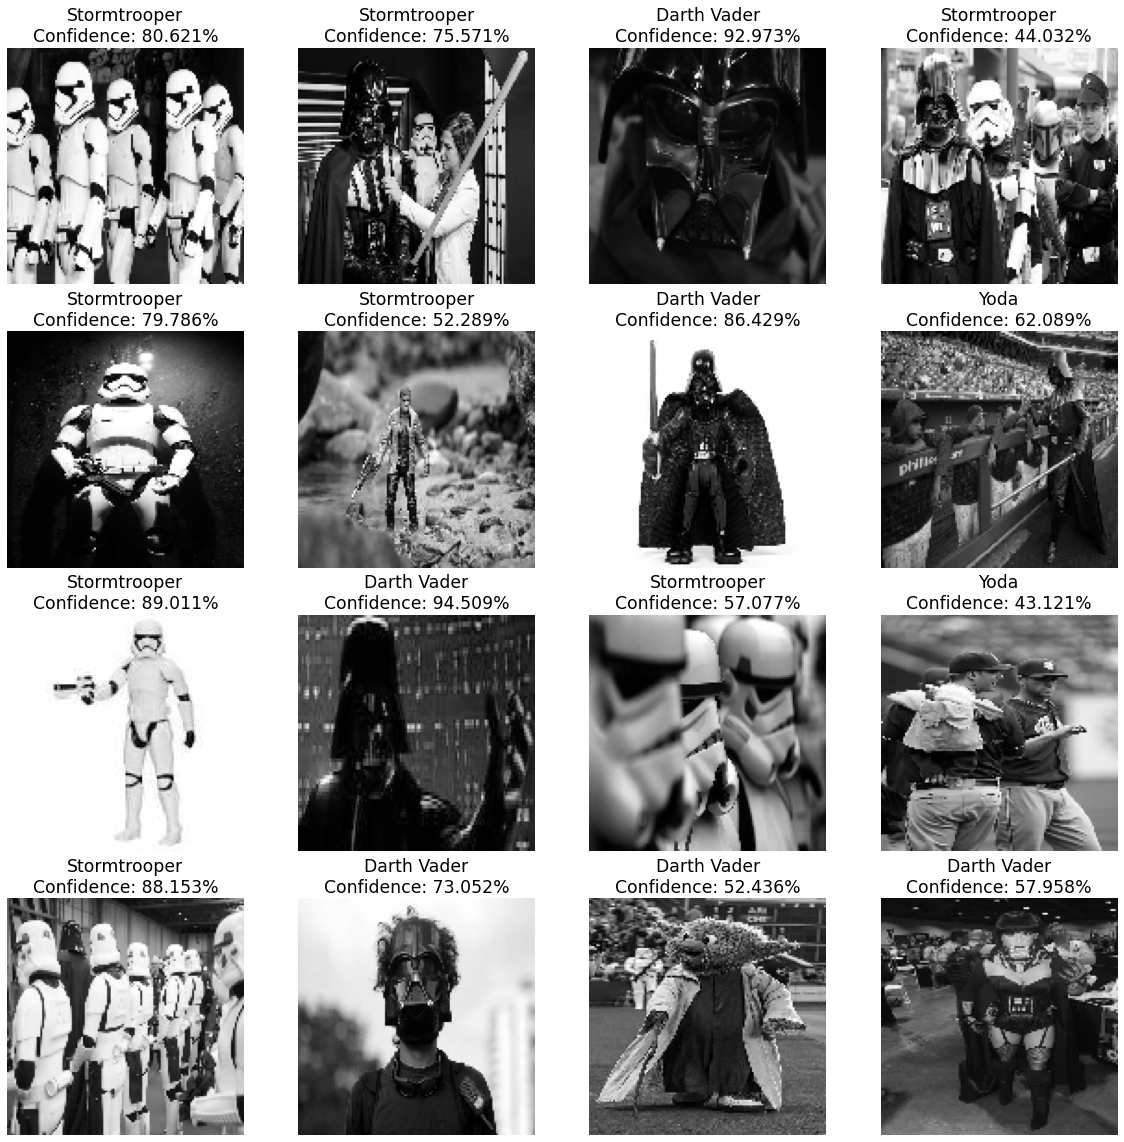

In [33]:
plt.figure(figsize=(20, 20))
for i, img in enumerate(X_test[:16]):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.reshape(h, w), cmap='gray')
    lbl = classLabels[y_predict_svm[i]] + '\nConfidence: ' + str(round(y_prob_svm[i][y_predict_svm[i]]*100, 3)) + '%'
    plt.title(lbl)
    plt.axis("off")

### KNN

In [34]:
modelo_knn = knn(n_neighbors=3)

In [35]:
modelo_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [36]:
y_predict_knn = modelo_knn.predict(X_test)
y_prob_knn = modelo_knn.predict_proba(X_test)

In [37]:
acc_knn = accuracy_score(y_test, y_predict_knn)
print(f'Acuracia do modelo knn: {round(acc_knn*100, 2)}%')

Acuracia do modelo knn: 51.64%


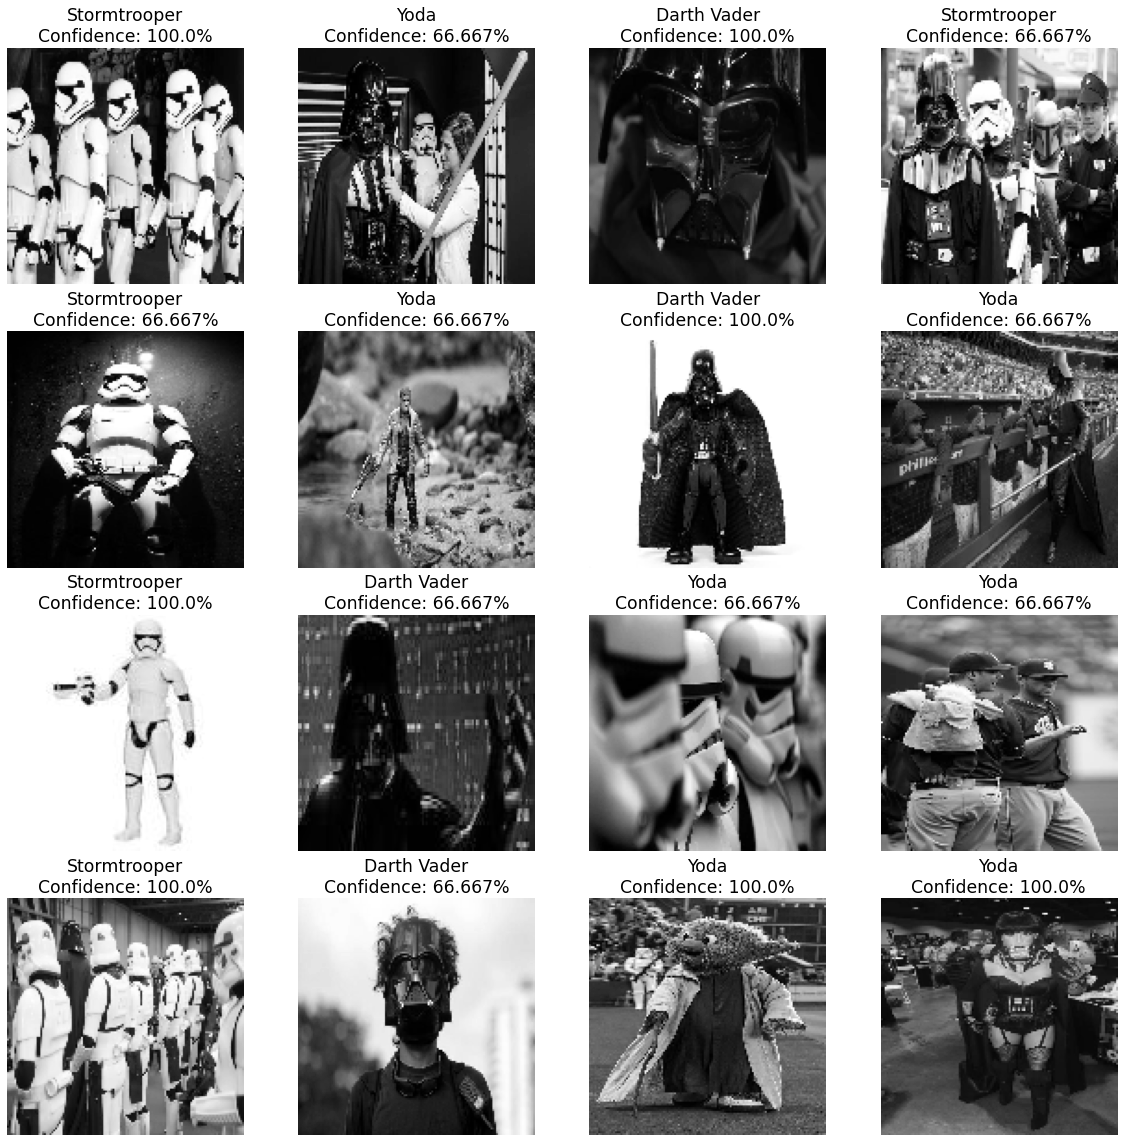

In [38]:
plt.figure(figsize=(20, 20))
for i, img in enumerate(X_test[:16]):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.reshape(h, w), cmap='gray')
    lbl = classLabels[y_predict_knn[i]] + '\nConfidence: ' + str(round(y_prob_knn[i][y_predict_knn[i]]*100, 3)) + '%'
    plt.title(lbl)
    plt.axis("off")

### Florestas Aleatorias

In [39]:
modelo_rf = rfc(n_estimators=200)

In [40]:
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [41]:
y_predict_rf = modelo_rf.predict(X_test)
y_prob_rf = modelo_rf.predict_proba(X_test)

In [42]:
acc_rf = accuracy_score(y_test, y_predict_rf)
print(f'Acuracia do modelo knn: {round(acc_rf*100, 2)}%')

Acuracia do modelo knn: 66.36%


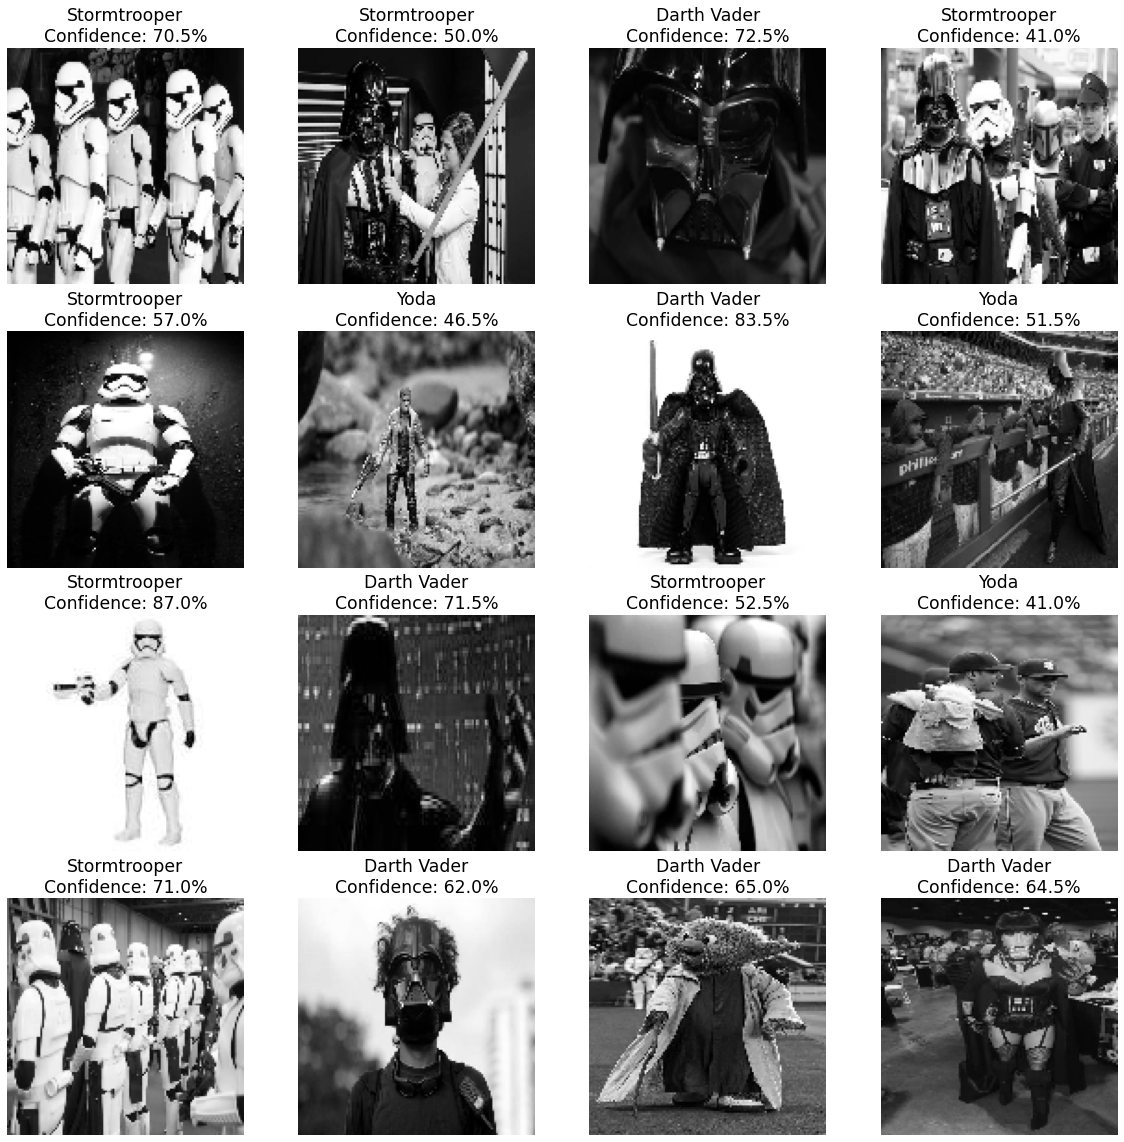

In [43]:
plt.figure(figsize=(20, 20))
for i, img in enumerate(X_test[:16]):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.reshape(h, w), cmap='gray')
    lbl = classLabels[y_predict_rf[i]] + '\nConfidence: ' + str(round(y_prob_rf[i][y_predict_rf[i]]*100, 3)) + '%'
    plt.title(lbl)
    plt.axis("off")

## Tarefa 4 - Classificação com CNN

* [Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn)
* [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/)
* [Regularization layers](https://keras.io/api/layers/regularization_layers/)
* [Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)
* [flatten layer](https://keras.io/api/layers/reshaping_layers/flatten/)

In [44]:
epocas = 20

In [45]:
def plot_metricas(hist:keras.callbacks.History, n_epocas:int): 
    """
    Plotas dois graficos, um com a acuracia e outro com o custo, ambos para treino e validacao
    
    @input
        hist(keras.callbacks.History): historico do treinamento da rede
        n_epocas = numero de epocas do treinamento
    """
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = range(n_epocas)

    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label = 'Treino', c='#44c0e2')
    plt.plot(epochs_range, val_acc, label = 'Validação', c='#e26644')
    plt.title('Acurácia')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Treino', c='#44c0e2')
    plt.plot(epochs_range, val_loss, label = 'Validação', c='#e26644')
    plt.title('Custo')
    plt.show()

In [46]:
type(test_set)

keras.preprocessing.image.DirectoryIterator

In [47]:
def plot_pred_imgs(mod, conj_teste, labelsDict:dict, tipo:str):
    """
    Plota uma matriz (9x9) de imagens com as prediçoes do modelo
    
    @input:
        mod(keras.engine.functional.Functional): modelo treinado 
        conj_teste(keras.preprocessing.image.DirectoryIterator): conjunto de teste
        labelsDict(dict): dicionarios associando a classificacao numerica a string
        tipo(str): tipo da imagem de saida, uint8 ou float32
    """
    image_batch, label_batch = next(iter(conj_teste))
    predictions = mod.predict_on_batch(image_batch)

    predictions = tf.nn.sigmoid(predictions)

    predictions = tf.nn.sigmoid(predictions)
    predictions = [i.argmax() for i in predictions.numpy()]

    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].astype(tipo))
        plt.title(np.array(labelsDict[predictions[i]]))
        plt.axis("off")

### CNN Simples

In [48]:
modelo_cnn_simples = Sequential()
modelo_cnn_simples.add(keras.Input(shape=(h, w, 3)))
modelo_cnn_simples.add(Conv2D(32, kernel_size=(3, 3)))
modelo_cnn_simples.add(Activation(activations.relu))
modelo_cnn_simples.add(Flatten())
modelo_cnn_simples.add(Dropout(0.5))
modelo_cnn_simples.add(Dense(len(wwd.classes)))

In [49]:
modelo_cnn_simples.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [50]:
print(modelo_cnn_simples.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 508032)            0         
_________________________________________________________________
dropout (Dropout)            (None, 508032)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1524099   
Total params: 1,524,995
Trainable params: 1,524,995
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
hist_1 = \
modelo_cnn_simples.fit(train_set,
                       epochs=epocas,
                       validation_data=dev_set)

Epoch 1/20
26/26 [==============================] - 13s 371ms/step - loss: 4.1630 - accuracy: 0.4268 - val_loss: 1.0769 - val_accuracy: 0.5645
Epoch 2/20
26/26 [==============================] - 10s 367ms/step - loss: 1.0014 - accuracy: 0.5231 - val_loss: 0.9255 - val_accuracy: 0.5430
Epoch 3/20
26/26 [==============================] - 10s 369ms/step - loss: 0.8139 - accuracy: 0.6484 - val_loss: 0.7007 - val_accuracy: 0.6935
Epoch 4/20
26/26 [==============================] - 9s 356ms/step - loss: 0.6384 - accuracy: 0.7541 - val_loss: 0.5938 - val_accuracy: 0.7581
Epoch 5/20
26/26 [==============================] - 9s 371ms/step - loss: 0.6111 - accuracy: 0.7604 - val_loss: 0.6037 - val_accuracy: 0.7473
Epoch 6/20
26/26 [==============================] - 9s 362ms/step - loss: 0.5829 - accuracy: 0.7666 - val_loss: 0.7683 - val_accuracy: 0.7151
Epoch 7/20
26/26 [==============================] - 9s 364ms/step - loss: 0.5685 - accuracy: 0.7901 - val_loss: 0.6222 - val_accuracy: 0.7473
Epo

In [52]:
loss_m1, acc_m1 = modelo_cnn_simples.evaluate(test_set)
print(f'Loss: {loss_m1}\nAcc: {round(acc_m1*100, 2)}%')

8/8 [==============================] - 2s 209ms/step - loss: 0.6699 - accuracy: 0.7720
Loss: 0.669871985912323
Acc: 77.2%


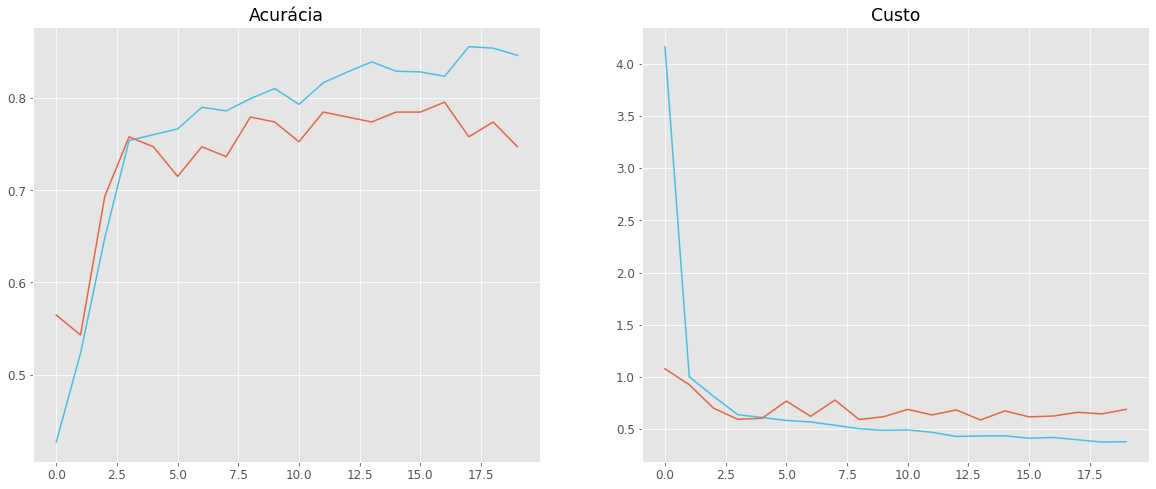

In [53]:
plot_metricas(hist_1, epocas)

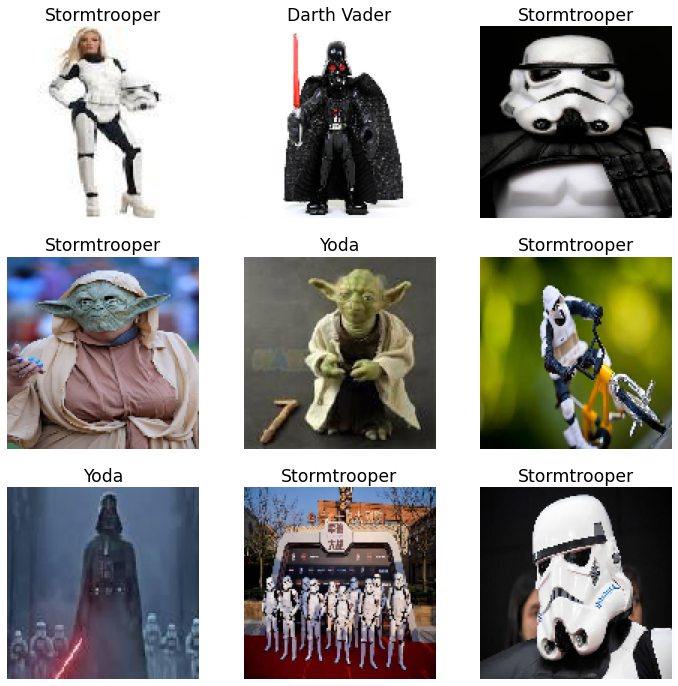

In [54]:
plot_pred_imgs(modelo_cnn_simples, test_set, classLabels, "float32")

### MaxPooling

In [55]:
modelo_cnn_mp = Sequential()
modelo_cnn_mp.add(keras.Input(shape=(h, w, 3)))
modelo_cnn_mp.add(Conv2D(32, kernel_size=(3, 3)))
modelo_cnn_mp.add(Activation(activations.relu))
modelo_cnn_mp.add(MaxPooling2D())
modelo_cnn_mp.add(Flatten())
modelo_cnn_mp.add(Dropout(0.5))
modelo_cnn_mp.add(Dense(len(wwd.classes)))

In [56]:
modelo_cnn_mp.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [57]:
print(modelo_cnn_mp.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127008)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 381027    
Total params: 381,923
Trainable params: 381,923
Non-trainable params: 0
________________________________________________

In [58]:
hist_2 = \
modelo_cnn_mp.fit(
    train_set,
    epochs=epocas,
    validation_data=dev_set)

Epoch 1/20
26/26 [==============================] - 10s 391ms/step - loss: 0.7267 - accuracy: 0.4534 - val_loss: 0.5510 - val_accuracy: 0.6398
Epoch 2/20
26/26 [==============================] - 10s 369ms/step - loss: 0.5145 - accuracy: 0.6413 - val_loss: 0.4515 - val_accuracy: 0.7097
Epoch 3/20
26/26 [==============================] - 9s 364ms/step - loss: 0.4235 - accuracy: 0.7353 - val_loss: 0.3921 - val_accuracy: 0.7688
Epoch 4/20
26/26 [==============================] - 10s 374ms/step - loss: 0.3831 - accuracy: 0.7682 - val_loss: 0.3752 - val_accuracy: 0.7634
Epoch 5/20
26/26 [==============================] - 10s 369ms/step - loss: 0.3587 - accuracy: 0.7800 - val_loss: 0.3693 - val_accuracy: 0.7796
Epoch 6/20
26/26 [==============================] - 9s 357ms/step - loss: 0.3459 - accuracy: 0.7894 - val_loss: 0.3781 - val_accuracy: 0.7688
Epoch 7/20
26/26 [==============================] - 10s 367ms/step - loss: 0.3458 - accuracy: 0.7635 - val_loss: 0.3809 - val_accuracy: 0.7796
E

In [59]:
loss_m2, acc_m2 = modelo_cnn_mp.evaluate(test_set)
print(f'Loss: {loss_m2}\nAcc: {round(acc_m2*100, 2)}%')

8/8 [==============================] - 2s 208ms/step - loss: 0.3313 - accuracy: 0.8077
Loss: 0.3312546908855438
Acc: 80.77%


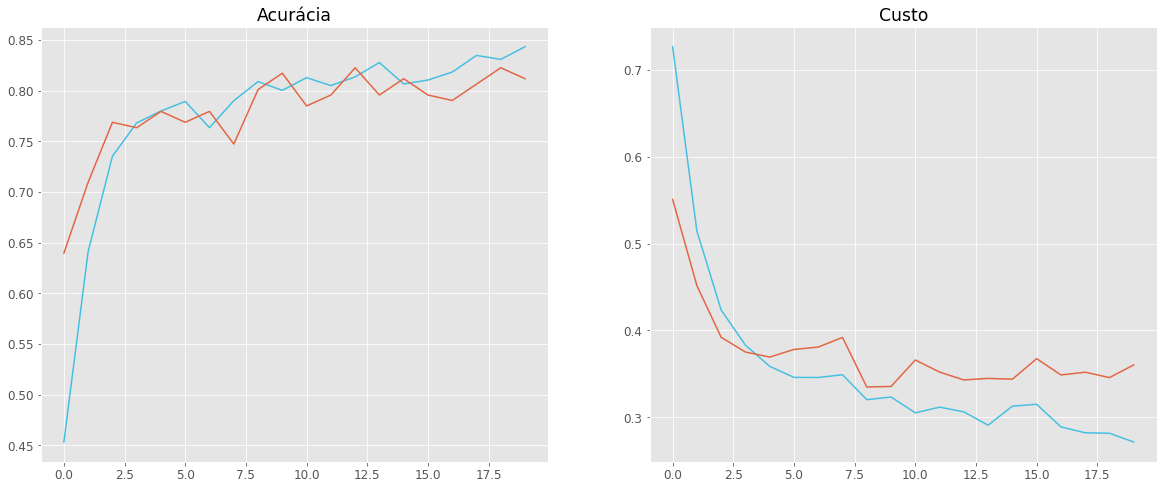

In [60]:
plot_metricas(hist_2, epocas)

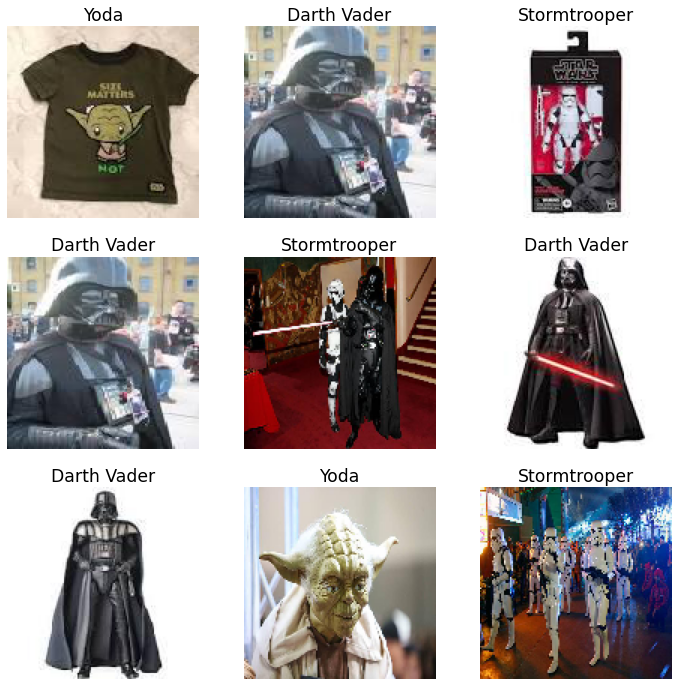

In [61]:
plot_pred_imgs(modelo_cnn_mp, test_set, classLabels, "float32")

### Mais camadas 

In [62]:
modelo_cnn = Sequential()

modelo_cnn.add(keras.Input(shape=(h, w, 3)))

modelo_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
#modelo_cnn.add(Activation(activations.relu))

modelo_cnn.add(MaxPooling2D())

modelo_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#modelo_cnn.add(Activation(activations.relu))

modelo_cnn.add(MaxPooling2D())

modelo_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#modelo_cnn.add(Activation(activations.relu))

modelo_cnn.add(Flatten())

modelo_cnn.add(Dense(64, activation='relu'))
#modelo_cnn.add(Activation(activations.relu))

modelo_cnn.add(Dense(len(wwd.classes)))

In [63]:
modelo_cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [64]:
print(modelo_cnn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [65]:
hist_3 = \
modelo_cnn.fit(
    train_set,
    epochs=epocas,
    validation_data=dev_set)

Epoch 1/20
26/26 [==============================] - 10s 370ms/step - loss: 0.5747 - accuracy: 0.5145 - val_loss: 0.4800 - val_accuracy: 0.6344
Epoch 2/20
26/26 [==============================] - 10s 379ms/step - loss: 0.4426 - accuracy: 0.6938 - val_loss: 0.3754 - val_accuracy: 0.7366
Epoch 3/20
26/26 [==============================] - 10s 370ms/step - loss: 0.3546 - accuracy: 0.7713 - val_loss: 0.3738 - val_accuracy: 0.7742
Epoch 4/20
26/26 [==============================] - 9s 364ms/step - loss: 0.3260 - accuracy: 0.7894 - val_loss: 0.3164 - val_accuracy: 0.8226
Epoch 5/20
26/26 [==============================] - 9s 357ms/step - loss: 0.3027 - accuracy: 0.8074 - val_loss: 0.3561 - val_accuracy: 0.7688
Epoch 6/20
26/26 [==============================] - 9s 358ms/step - loss: 0.3089 - accuracy: 0.8050 - val_loss: 0.3421 - val_accuracy: 0.7849
Epoch 7/20
26/26 [==============================] - 10s 369ms/step - loss: 0.2904 - accuracy: 0.8238 - val_loss: 0.2889 - val_accuracy: 0.8387
Ep

In [66]:
loss_m3, acc_m3 = modelo_cnn.evaluate(test_set)
print(f'Loss: {loss_m3}\nAcc: {round(acc_m3*100, 2)}%')

8/8 [==============================] - 2s 217ms/step - loss: 0.3073 - accuracy: 0.8324
Loss: 0.3072892129421234
Acc: 83.24%


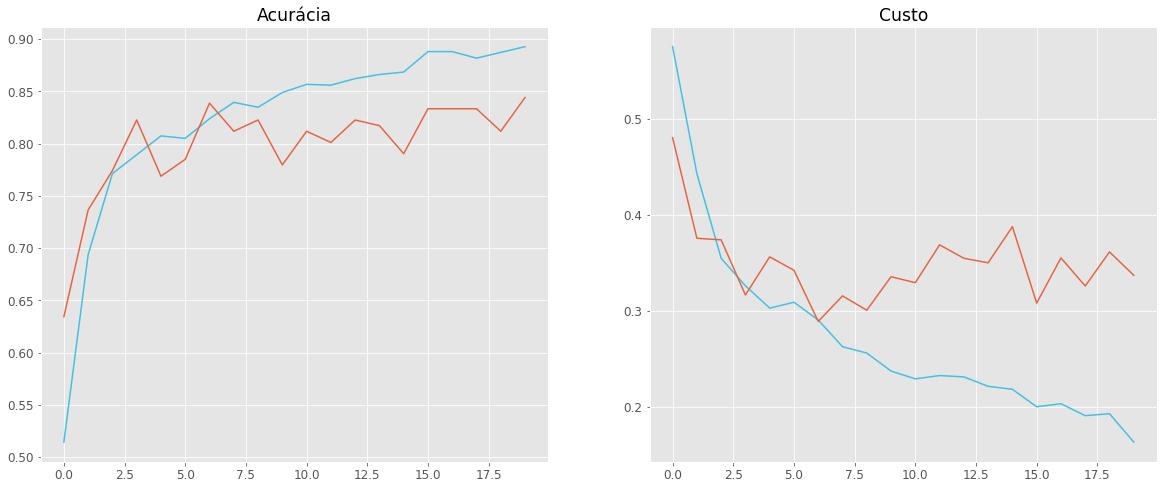

In [67]:
plot_metricas(hist_3, epocas)

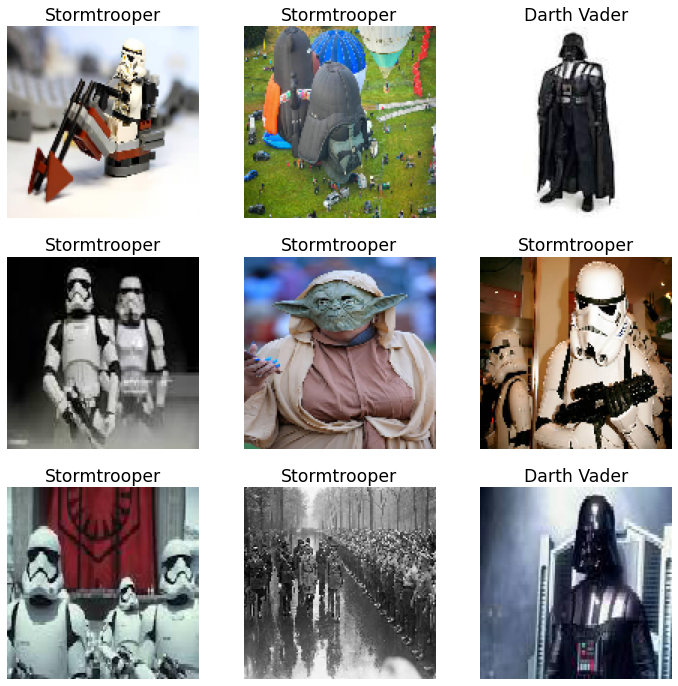

In [68]:
plot_pred_imgs(modelo_cnn, test_set, classLabels, "float32")

## Tarefa 5 - Transfer Learning

* [Transfer Learning com Tf](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [69]:
h1, w1 = 160, 160

In [71]:
gen_treino = img_gen(horizontal_flip=True, rotation_range=45)
gen_teste = img_gen()


train_tl_mnet = gen_treino.flow_from_directory(
    wwd.dirs['treino'],
    target_size=(h1, w1), 
    shuffle=True, 
    batch_size=100, 
    class_mode="sparse")

dev_tl_mnet = gen_teste.flow_from_directory(
    wwd.dirs['dev'],
    target_size=(h1, w1),
    shuffle=True,
    batch_size=100, 
    class_mode="sparse")

test_tl_mnet = gen_teste.flow_from_directory(
    wwd.dirs['teste'],
    target_size=(h1, w1), 
    shuffle=True,
    batch_size=100,
    class_mode="sparse")

Found 1277 images belonging to 3 classes.
Found 186 images belonging to 3 classes.
Found 364 images belonging to 3 classes.


In [72]:
classLabels1 = dict(zip(train_tl_mnet.class_indices.values(), train_tl_mnet.class_indices.keys()))
classLabels1

{0: 'Darth Vader', 1: 'Stormtrooper', 2: 'Yoda'}

In [73]:
modelo_mnet = MobileNetV2(
    input_shape=(h1, w1, 3),
    include_top=False,
    weights='imagenet')

In [74]:
modelo_mnet.trainable = False

In [75]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [76]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [77]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [78]:
inputs = tf.keras.Input(shape=(h1, w1, 3))

#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = modelo_mnet(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(3)(x)

modelo = tf.keras.Model(inputs, outputs)

In [79]:
modelo.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3843  

In [80]:
modelo.compile(optimizer='adam',
               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [81]:
hist = \
    modelo.fit(train_tl_mnet, 
               epochs=10, 
               validation_data=dev_tl_mnet)

Epoch 1/10
13/13 [==============================] - 14s 948ms/step - loss: 1.1525 - accuracy: 0.4847 - val_loss: 0.6032 - val_accuracy: 0.7581
Epoch 2/10
13/13 [==============================] - 11s 846ms/step - loss: 0.6067 - accuracy: 0.7431 - val_loss: 0.3670 - val_accuracy: 0.9086
Epoch 3/10
13/13 [==============================] - 11s 842ms/step - loss: 0.4478 - accuracy: 0.8238 - val_loss: 0.2975 - val_accuracy: 0.9086
Epoch 4/10
13/13 [==============================] - 11s 836ms/step - loss: 0.3878 - accuracy: 0.8481 - val_loss: 0.2781 - val_accuracy: 0.9086
Epoch 5/10
13/13 [==============================] - 11s 827ms/step - loss: 0.3323 - accuracy: 0.8724 - val_loss: 0.2751 - val_accuracy: 0.8925
Epoch 6/10
13/13 [==============================] - 11s 873ms/step - loss: 0.3432 - accuracy: 0.8684 - val_loss: 0.2640 - val_accuracy: 0.9032
Epoch 7/10
13/13 [==============================] - 11s 833ms/step - loss: 0.3101 - accuracy: 0.8786 - val_loss: 0.2711 - val_accuracy: 0.8925

In [82]:
loss_tl, acc_tl = modelo.evaluate(test_tl_mnet)
print(f'Loss: {loss_tl}\nAcc: {round(acc_tl*100, 2)}%')

4/4 [==============================] - 2s 561ms/step - loss: 0.2811 - accuracy: 0.9038
Loss: 0.2811305820941925
Acc: 90.38%


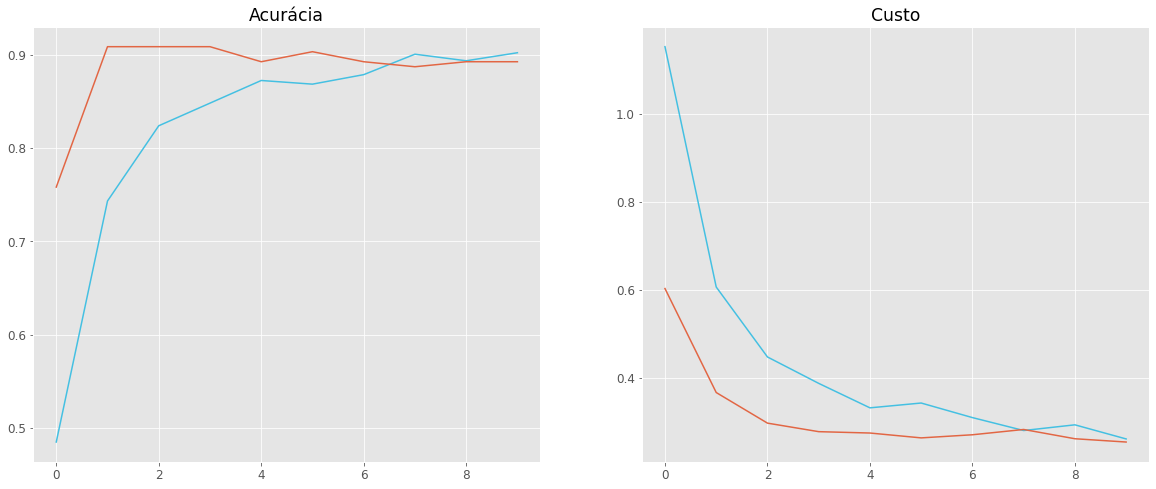

In [83]:
plot_metricas(hist, 10)

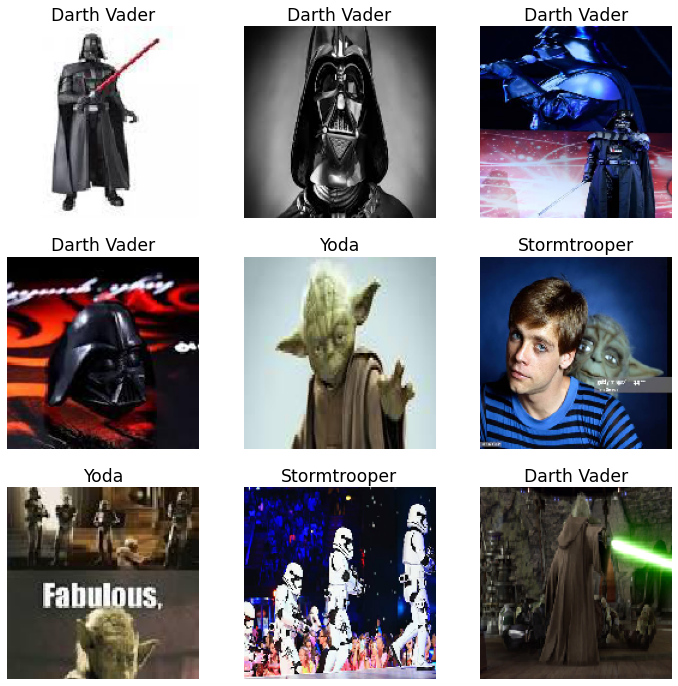

In [84]:
plot_pred_imgs(modelo, test_tl_mnet, classLabels, "uint8")

## Comparaçao dos modelos 

In [85]:
comp_acc_dl = {
    "CNN Simples":acc_m1,
    "CNN MaxPooling":acc_m2,
    "CNN com + camadas":acc_m3,
    "TL com MobileNet":acc_tl
}

comp_acc_ml = {
    "KNN":acc_knn,
    "SVM":acc_svm,
    "Florestas Aleatorias":acc_rf,
    "Regressao Logistica":acc_rl
}

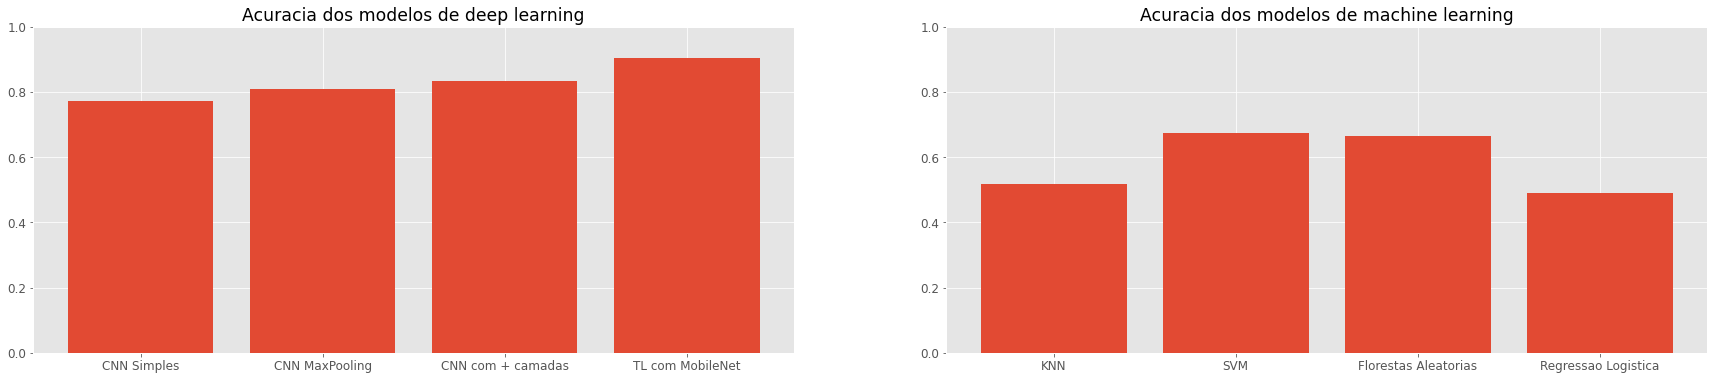

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(30, 6))

ax[0].bar(x=list(comp_acc_dl.keys()), height=list(comp_acc_dl.values()))
ax[1].bar(x=list(comp_acc_ml.keys()), height=list(comp_acc_ml.values()))

ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)

ax[0].set_title('Acuracia dos modelos de deep learning')
g = ax[1].set_title('Acuracia dos modelos de machine learning')

Os modelos de machine learning não obtiveram bom desempenho no geral, por ser uma classificacao relativamente complexa ja que as imagens possuem cenario, e nao foram tratadas anteriormente, apenas o augmentation é esperado que ml tenha mal desempenho. 
Quanto aos modelos de deep learning todos se sariam bem, com acuracia acima de 70%, sendo que ao adiconar mais camadas (convoluçao, dense e maxpooling) a acuracia e custo foram bons, e com transfer learning usando MobileNet foi o modelo com melhor perfomance.